# Random Forest

In [1]:
%matplotlib inline
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
import pydotplus 
from io import StringIO
from IPython.display import display, Image
from sklearn.externals.six import StringIO
import random
import seaborn as sns
import time

In [2]:
sns.set_style('whitegrid')
sns.set(color_codes=True)

In [3]:
# split into 9 levels
def MoneyToCate(input_list):
    out = [];
    for m in input_list:
        if m <= 1000000:
            out.append(0)
        elif m > 1000000 and m <= 10000000:
            out.append(1)
        elif m > 10000000 and m <= 20000000:
            out.append(2)
        elif m > 20000000 and m <= 40000000:
            out.append(3)
        elif m > 40000000 and m <= 65000000:
            out.append(4)
        elif m > 64000000 and m <= 100000000:
            out.append(5)
        elif m > 100000000 and m <= 150000000:
            out.append(6)
        elif m > 150000000 and m <= 200000000:
            out.append(7)
        else:
            out.append(8)
    return(out)

In [4]:
def Bag(input_list, bag_list):
    n = len(bag_list)
    output = []
    for obs in input_list:
        feature = [0]*n
        for word in bag_list:
            if word in obs:
                feature[bag_list.index(word)] = 1
        output.append(feature)
    return output

In [29]:
table1 = pd.read_excel("Data Merged( Kaggle TMDB Studio, no NAs).xlsx", index_col=0)
table1.columns

Index([                   'studio',             'director_name',
         'director_facebook_likes',    'num_critic_for_reviews',
          'actor_1_facebook_likes',    'actor_2_facebook_likes',
          'actor_3_facebook_likes', 'cast_total_facebook_likes',
                          'genres',                  'genres.1',
                     'Unnamed: 11',               'Unnamed: 12',
                     'Unnamed: 13',               'Unnamed: 14',
                     'Unnamed: 15',           'num_voted_users',
                   'plot_keywords',               'Unnamed: 18',
                     'Unnamed: 19',               'Unnamed: 20',
                     'Unnamed: 21',               'Unnamed: 22',
            'num_user_for_reviews',                'imdb_score',
                    'aspect_ratio',      'movie_facebook_likes',
                          'rating',                      'Year',
                          'Status',                  'Language',
                         

In [30]:
genre = np.matrix(table1[['genres.1', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15']]).tolist()
bag_genre = list(set([val for sublist in genre for val in sublist]))
bag_genre.remove(bag_genre[0])

In [31]:
keywords = np.matrix(table1[['Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22']]).tolist()
bag_keywords = list(set([val for sublist in keywords for val in sublist]))
bag_keywords.remove(bag_keywords[0])

In [32]:
actor = np.matrix(table1[[8, 9, 10, 11, 12, 13]]).tolist()
bag_actor = list(set([val for sublist in actor for val in sublist]))
bag_actor.remove(bag_actor[0])

In [33]:
table1['Sign'] = np.sign(np.subtract(table1['Revenue'], table1['Budget']))
table1['Sign'][table1['Sign']==0] = 1
#table1['Sign'][table1['Sign']==-1] = 0
# table1['Revenue'] = MoneyToCate(list(table1['Revenue']))
table1['Budget'] = MoneyToCate(list(table1['Budget']))
table1['Annual Average Revenue'] = MoneyToCate(list(table1['Annual Average Revenue']))
table1_director_name = pd.get_dummies(table1['director_name']).values
table1_genres = Bag(genre, bag_genre)
table1_keywords = Bag(keywords, bag_keywords)
table1_actor = Bag(actor, bag_actor)
table1_studio = pd.get_dummies(table1['studio']).values
table1_rating = pd.get_dummies(table1['rating']).values
table1_Language = pd.get_dummies(table1['Language']).values
table1 = table1.drop(['genres', 'genres.1', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
                      'plot_keywords', 'Annual Average Budget', 'Revenue',
                      'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'rating', 'Status', 'Runtime', 
                      8, 9, 10, 11, 12, 13, 'director_name', 'studio', 'Language'], axis=1)
table2 = table1.drop('Sign', axis=1)

/Users/admin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [34]:
Y = table1['Sign']
X = np.column_stack([table2, table1_director_name, table1_genres, table1_keywords, table1_actor, table1_studio, 
                     table1_rating, table1_Language])
X.shape

(2409, 11943)

In [35]:
# all genres and counts
Allgenres = list([val for sublist in genre for val in sublist])
Allgenres = Counter(Allgenres)
del Allgenres[list(Allgenres.keys())[0]]
Allgenres

Counter({'Action': 704,
         'Adventure': 587,
         'Animation': 149,
         'Biography': 164,
         'Comedy': 901,
         'Crime': 462,
         'Documentary': 15,
         'Drama': 1136,
         'Family': 301,
         'Fantasy': 342,
         'Film-Noir': 3,
         'History': 101,
         'Horror': 225,
         'Music': 89,
         'Musical': 48,
         'Mystery': 271,
         'News': 1,
         'Romance': 523,
         'Sci-Fi': 361,
         'Sport': 94,
         'Thriller': 781,
         'War': 100,
         'Western': 41})

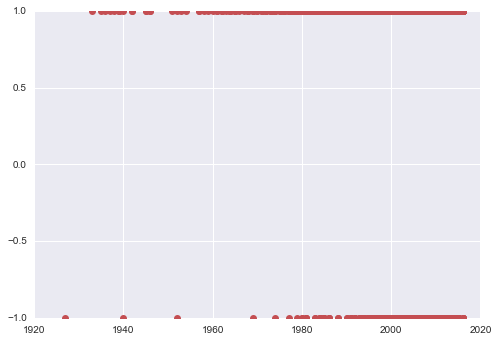

In [35]:
plt.plot(table1['Year'], table1['Sign'], 'ro')
plt.show()

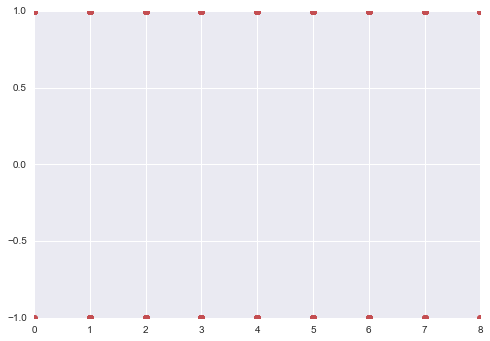

In [36]:
plt.plot(table1['Budget'], table1['Sign'], 'ro')
plt.show()

In [37]:
# Cross-Validation for selecting max_features
score_decision = []
for i in range(20):
    clf = tree.DecisionTreeClassifier(max_features=(i+1)/20, random_state=0)
    score = cross_val_score(clf, X, Y, cv=5).mean()
    score_decision.append(score)
    print([i, score]) 

[0, 0.7400756705104532]
[1, 0.75170430822604728]
[2, 0.75376953637823196]
[3, 0.76042750825359517]
[4, 0.75918355048789832]
[5, 0.74712189494798198]
[6, 0.74834347008260049]
[7, 0.7608295347425782]
[8, 0.75458908502386768]
[9, 0.754573589356198]
[10, 0.74461504026721426]
[11, 0.7658105310279224]
[12, 0.76082609126087397]
[13, 0.76375563332085072]
[14, 0.74960292351596691]
[15, 0.75832268006181047]
[16, 0.76374702461658983]
[17, 0.75293793554663113]
[18, 0.75876602833124573]
[19, 0.75957524653176833]


In [38]:
max_feature = [(x+1)/20 for x in range(20)]
DecisionTree = pd.DataFrame()
DecisionTree["max_features"] = max_feature
DecisionTree["precision"] = score_decision
DecisionTree.to_csv("Decision Tree Precision.csv")

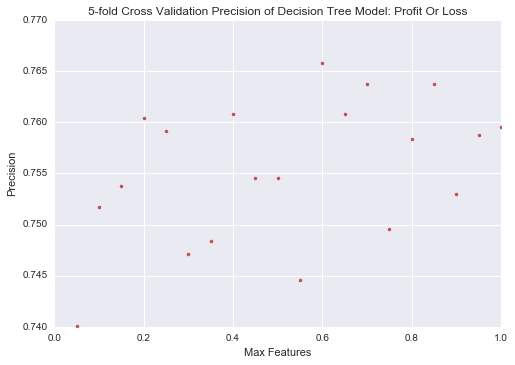

In [41]:
plt.plot(max_feature, score_decision, 'r.')
plt.xlabel('Max Features')
plt.ylabel('Precision')
plt.title('5-fold Cross Validation Precision of Decision Tree Model: Profit Or Loss')
plt.savefig('DecisionTree Profit Or Loss.pdf')
plt.show()

In [42]:
clf = tree.DecisionTreeClassifier(random_state=0)
clf.fit(X, Y)
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data,
                     class_names=["Loss", "Profit"],
                     filled=True, rounded=True,
                     special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('Decision Tree Compared with Profit Or Loss.png')

True

In [ ]:
clf = tree.DecisionTreeClassifier(random_state=0)
clf.fit(X, Y)
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data,
                     class_names=["loss", "profit"],
                     filled=True, rounded=True,
                     special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
display(Image(graph.create_png()))

0: 0.781640216423
1: 0.783724383724
2: 0.78123130297
3: 0.783310305049
4: 0.788715710455
5: 0.785805107544
6: 0.78622090796
7: 0.787468309207
8: 0.785389307128
9: 0.78622090796
10: 0.787884109623
11: 0.78622090796
12: 0.786636708376
13: 0.787884109623
14: 0.784557706297
15: 0.784973506713
16: 0.784973506713
17: 0.78622090796
18: 0.784973506713
19: 0.786636708376
20: 0.787052508792
21: 0.788299910039
22: 0.788299910039
23: 0.789131510871
24: 0.788715710455
25: 0.789547311286
26: 0.790378912118
27: 0.789547311286
28: 0.790378912118
29: 0.790378912118
30: 0.789547311286
31: 0.789547311286
32: 0.789547311286
33: 0.789963111702
34: 0.789131510871
35: 0.789547311286
36: 0.789131510871
37: 0.789547311286
38: 0.790378912118
39: 0.790794712534
40: 0.789963111702
41: 0.789963111702
42: 0.790794712534
43: 0.789963111702
44: 0.789963111702
45: 0.790378912118
46: 0.789963111702
47: 0.789963111702
48: 0.79121051295
49: 0.791626313365
Time elapsed: 7897.593013048172sec.



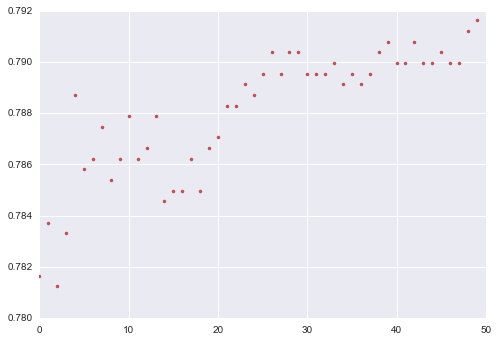

In [40]:
# Cross-Validation for selecting n_estimators 
start = time.time()
score = []
for i in range(50):
    clf = RandomForestClassifier(n_estimators=10*(i+1), min_samples_split=2, random_state=0)
    scores = cross_val_score(clf, X, Y, cv=5)
    score.append(scores.mean())
    print(str(i) + ": " + str(scores.mean()))
print("Time elapsed: " + str(time.time()-start) + "sec.\n")
plt.plot(range(50), score, 'r.')
plt.show()

In [49]:
n_estimators = [10*(x+1) for x in range(50)]
RandomForest = pd.DataFrame()
RandomForest["n_estimators"] = n_estimators
RandomForest["precision"] = score
RandomForest.to_csv("Random Forest Precision Compared with Profit Or Loss.csv")

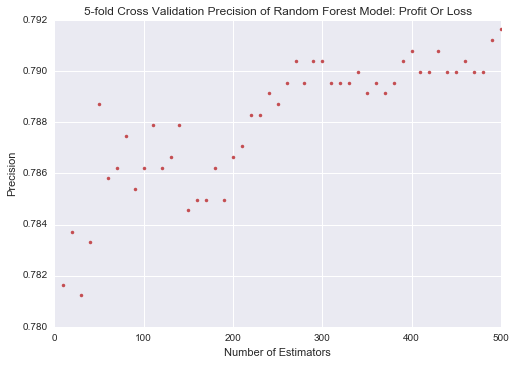

In [51]:
plt.plot(n_estimators, score, 'r.')
plt.xlabel('Number of Estimators')
plt.ylabel('Precision')
plt.title('5-fold Cross Validation Precision of Random Forest Model: Profit Or Loss')
plt.savefig('RandomForest Compared with Profit Or Loss.pdf')
plt.show()

In [ ]:
# Cross-Validation for selecting n_estimators and max_feature
start = time.time()
scores = []
n_estimators = []
max_features = []
for i in range(25):
    for j in range(5):
        clf = RandomForestClassifier(n_estimators=20*(i+1), max_features=(j+1)/5, min_samples_split=2, random_state=0)
        score = cross_val_score(clf, X, Y, cv=5).mean()
        n_estimators.append(i)
        max_features.append(j)
        scores.append(score)
        print([i, j, score])
print("Time elapsed: " + str(time.time()-start) + "sec.\n")

In [107]:
clf = RandomForestClassifier(n_estimators=250, min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X, Y, cv=5)
scores.mean()

0.29015140787034766

In [50]:
clf = ExtraTreesClassifier(n_estimators=220, max_depth=None,
     min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X, Y, cv=5)
scores.mean()

0.32124161679559576

In [38]:
Budget = MoneyToCate2(list(table1['Budget']))
Counter(Budget).values()

dict_values([53, 49, 752, 616, 373, 319, 156, 65, 26])

In [12]:
Revenue = MoneyToCate(list(table1['Revenue']))
Counter(Revenue).values()

dict_values([200, 224, 345, 309, 302, 284, 307, 196, 242])

In [8]:
# majority vote
def Majority(pred_tuple, weight_list):
    pred_major = []
    for pred in pred_tuple:
        pred_dic = {}
        for yhat, w in zip(pred, weight_list):
            if yhat in pred_dic:
                pred_dic[yhat] += w
            else:
                pred_dic[yhat] = w
        maxium = max(pred_dic, key=pred_dic.get)
        pred_major.append(maxium)
#         print(pred)
#         print(maxium)
    return(pred_major)